In [5]:
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%pwd

'/dgx1nas1/storage/data/aquach/deepscm/deepscm/experiments/celeba/sem_vi'

In [3]:
split_dir = "../../../../assets/data/celeba"
# split_dir = "../../../../../../../../dgx1nas1/storage/data/jcaicedo/dsae/celebA"
# celeba_train = CelebaEmbedDataset(npy_path=, csv_path=f'{split_dir}/train_features.csv')
embed_train = np.load(f'{split_dir}/train_features.npy')
embed_valid = np.load(f'{split_dir}/val_features.npy')
embed_test  = np.load(f'{split_dir}/test_features.npy')

In [19]:
split_dir = "../../../../assets/data/celeba"
df_train = pd.read_csv(f'{split_dir}/train_features.csv')
df_valid = pd.read_csv(f'{split_dir}/val_features.csv')
df_test = pd.read_csv(f'{split_dir}/test_features.csv')

# UMAP

In [5]:
reducer = umap.UMAP(random_state=42)
reducer.fit(embed_train.data)

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [6]:
embedding_valid = reducer.transform(embed_valid)

In [7]:
embedding_train = reducer.transform(embed_train)

In [8]:
embed_v88 = np.load(f'./v88.npy')
embedding_v88 = reducer.transform(embed_v88)

In [9]:
embedding_valid_2 = embedding_valid[1:]

In [10]:
colors = []
descriptions = []

# blue, pink
blue = [70 / 255.0, 130 / 255.0, 180 / 255.0]
pink = [255 / 255.0, 192 / 255.0, 203 / 255.0]

c_train = [blue if item > 0 else pink for item in df_train['Male']]

# green, maroon
green = [34 / 255.0, 139 / 255.0, 34 / 255.0]
maroon = [220 / 255.0, 20 / 255.0, 60 / 255.0]
c_valid = [green if item > 0 else maroon for item in df_valid['Male']]

colors.append(blue)
colors.append(pink)
descriptions.append("train male")
descriptions.append("train female")

colors.append(green)
colors.append(maroon)
descriptions.append("valid male")
descriptions.append("valid female")

In [11]:
#array with rainbow colors (rgb)
# [black, red, orange, yellow, green, blue, indigo, pink]
rainbow = list(np.array([[0, 0, 0], [255, 0, 0], [255, 127, 0], [255, 255, 0], [0, 128, 0], [0, 0, 255], [75, 0, 130], [238, 130, 238]]) / 255.0)
c_v88 = [rainbow[i%8] for i in range(embed_v88.shape[0])]

rainbow_desc = ["original", "sex=female", "sex=male", "fh=0", "fh=1", "fh=2", "fh=3", "fh=4"]
colors.extend(rainbow)
descriptions.extend(rainbow_desc)

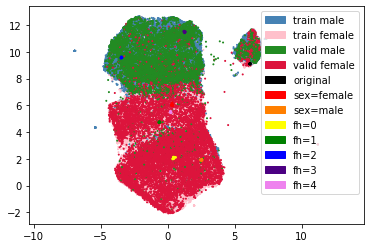

In [12]:
plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=c_train, s=1)
plt.scatter(embedding_valid_2[:, 0], embedding_valid_2[:, 1], c=c_valid, s=1)
plt.scatter(embedding_v88[:, 0], embedding_v88[:, 1], c=c_v88, s=3)
plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the Digits dataset', fontsize=24);

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, descriptions)] 
plt.legend(handles=handles)
plt.title('UMAP for original embeddings', fontsize=18)

In [13]:
!pwd

/dgx1nas1/storage/data/aquach/deepscm/deepscm/experiments/celeba/sem_vi


# Glow

In [1]:
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

split_dir = "../../../../assets/data/celeba"
# split_dir = "../../../../../../../../dgx1nas1/storage/data/jcaicedo/dsae/celebA"
# celeba_train = CelebaEmbedDataset(npy_path=, csv_path=f'{split_dir}/train_features.csv')
embed_train = np.load(f'{split_dir}/train_features.npy')
embed_valid = np.load(f'{split_dir}/val_features.npy')
embed_test  = np.load(f'{split_dir}/test_features.npy')

from tqdm import tqdm
from math import log, sqrt, pi

def calc_loss(log_p, logdet, num_features, n_bins):
    # log_p = calc_log_p([z_list])

    loss = -log(n_bins) * num_features
    loss = loss + logdet + log_p

    return (
        (-loss / (log(2) * num_features)).mean(),
        (log_p / (log(2) * num_features)).mean(),
        (logdet / (log(2) * num_features)).mean(),
    )

def train(dataset, model, optimizer, epochs, lr, device):
    with tqdm(enumerate(iter(dataset))) as pbar:
        for i, embed in pbar:
            # embed = next(dataset)
            embed = embed.to(device)
            embed_size = embed.shape[1]
            embed = embed.reshape(-1, 384, 1, 1)

            # dequantization
            # log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)
            log_p, logdet, _ = model(embed)

            logdet = logdet.mean()

            loss, log_p, log_det = calc_loss(log_p, logdet, 384, 256)

            model.zero_grad()
            loss.backward()
            
            # warmup_lr = args.lr * min(1, i * batch_size / (50000 * 10))
            warmup_lr = lr
            optimizer.param_groups[0]["lr"] = warmup_lr
            optimizer.step()

            pbar.set_description(
                f"Loss: {loss.item():.5f}; logP: {log_p.item():.5f}; logdet: {log_det.item():.5f}; lr: {warmup_lr:.7f}"
            )

            # if i % 100 == 0:
            #     with torch.no_grad():
            #         utils.save_image(
            #             model_single.reverse(z_sample).cpu().data,
            #             f"sample/{str(i + 1).zfill(6)}.png",
            #             normalize=True,
            #             nrow=10,
            #             range=(-0.5, 0.5),
            #         )

            # if i % 10000 == 0:
            #     torch.save(
            #         model.state_dict(), f"checkpoint/model_{str(i + 1).zfill(6)}.pt"
            #     )
            #     torch.save(
            #         optimizer.state_dict(), f"checkpoint/optim_{str(i + 1).zfill(6)}.pt"
            #     )

In [2]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(embed_train, batch_size=64, shuffle=True)

In [4]:
from glow import Flow, Glow
import torch
from torch import optim

n_flow = 32
n_block = 4
lr = 1e-4
epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Glow(
    384, n_flow, n_block, affine=True, conv_lu=True
).to(device)

# model = Flow(
#     384, affine=True, conv_lu=True
# ).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

# train(train_dataloader, model, optimizer, epochs, lr, device)

In [5]:
torch.save(
    model.state_dict(), f"./test.pt"
)

# Visualize Glow UMAPS

In [34]:
split_dir = "./"
embed_train = np.load(f'{split_dir}/train_embed_base.npy').reshape(-1, 384)
embed_valid = np.load(f'{split_dir}/valid_embed_base.npy').reshape(-1, 384)
# embed_test  = np.load(f'{split_dir}/test_features.npy')

In [13]:
embed_train.shape

(162770, 384)

reducer = umap.UMAP(random_state=42)
embedding_train = reducer.fit_transform(embed_train.data)
embedding_valid = reducer.tranasform(embed_valid.data)

In [46]:
reducer = umap.UMAP(random_state=42)
embedding_train = reducer.fit_transform(embed_train)


In [15]:
embedding_valid = reducer.transform(embed_valid)

In [16]:
embedding_valid_2 = embedding_valid[1:]

In [20]:
colors = []
descriptions = []

# blue, pink
blue = [70 / 255.0, 130 / 255.0, 180 / 255.0]
pink = [255 / 255.0, 192 / 255.0, 203 / 255.0]

c_train = [blue if item > 0 else pink for item in df_train['Male']]

# green, maroon
green = [34 / 255.0, 139 / 255.0, 34 / 255.0]
maroon = [220 / 255.0, 20 / 255.0, 60 / 255.0]
c_valid = [green if item > 0 else maroon for item in df_valid['Male']]

colors.append(blue)
colors.append(pink)
descriptions.append("train male")
descriptions.append("train female")

colors.append(green)
colors.append(maroon)
descriptions.append("valid male")
descriptions.append("valid female")

Text(0.5, 1.0, 'UMAP for Glow transformed embeddings')

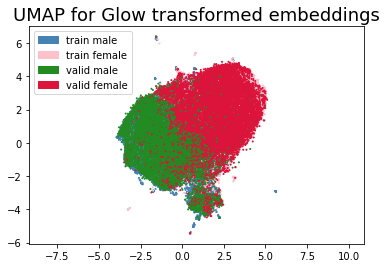

In [22]:
plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=c_train, s=1)
plt.scatter(embedding_valid_2[:, 0], embedding_valid_2[:, 1], c=c_valid, s=1)
# plt.scatter(embedding_v88[:, 0], embedding_v88[:, 1], c=c_v88, s=3)
plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the Digits dataset', fontsize=24);

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, descriptions)] 
plt.legend(handles=handles)
plt.title('UMAP for Glow transformed embeddings', fontsize=18)

# Compare Reconstructions

In [11]:
from glow import Flow, Glow
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

n_flow = 32
n_block = 1
lr = 1e-4
epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Glow(
    384, n_flow, n_block, affine=True, conv_lu=True
).to(device)
model.load_state_dict(torch.load(f"./model_base.pt"))



<All keys matched successfully>

In [12]:
def generate_forward_embeddings(model, device, dataset, filename):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    model.eval()
    with torch.no_grad():
        embeds = []
        for embed in tqdm(dataloader):
            embed = torch.Tensor(embed).to(device)
            embed = embed.reshape(-1, 384, 1, 1)
            log_p_sum, logdet, z_outs = model(embed)
            embeds.append(z_outs[0].cpu().numpy())
        embeds = np.concatenate(embeds)

    # save embeddings
    np.save(f"{filename}.npy", embeds)

In [31]:
def generate_reverse_embeddings(model, device, dataset, filename=None, reconstruct=True):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    model.eval()
    with torch.no_grad():
        embeds = []
        for z_embed in tqdm(dataloader):
            z_embed = torch.Tensor(z_embed).to(device)
            z_embed = z_embed.reshape(-1, 384, 1, 1)
            input = model.reverse([z_embed], reconstruct=reconstruct)
            embeds.append(input.cpu().numpy())
        embeds = np.concatenate(embeds)

    # save embeddings
    if filename:
        np.save(f"{filename}.npy", embeds)
    return embeds

In [6]:
train_z = np.load(f'./train_embed_base.npy').reshape(-1, 384)
valid_z = np.load(f'./valid_embed_base.npy').reshape(-1, 384)

In [33]:
train_recon = generate_reverse_embeddings(model, device, train_z, filename="./train_reconstruct_base")

100%|██████████| 2544/2544 [04:32<00:00,  9.34it/s]


In [43]:
train_RECON = generate_reverse_embeddings(model, device, train_z, filename="./train_reconstruct_base", reconstruct=True)

  0%|          | 0/2544 [00:00<?, ?it/s]/home/jupyter-aquach@broadinstit-9cd67/.local/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 2544/2544 [04:30<00:00,  9.41it/s]


In [ ]:
valid_recon = generate_reverse_embeddings(model, device, valid_z, filename="./valid_reconstruct_base", reconstruct=True)

In [44]:
print(train_RECON.shape)
train_RECON = train_RECON.reshape(-1, 384)

(162770, 384, 1, 1)


In [40]:
recon_diff_train = train_recon - embed_train

In [42]:
recon_diff_train

array([[ 0.8497398 ,  1.0692667 ,  1.2081476 , ...,  0.05063711,
        -0.10026187, -1.2802    ],
       [-0.37564   ,  1.1924379 , -0.23998839, ..., -2.85033   ,
         0.00987417, -1.2447468 ],
       [-0.52633035, -0.97676903,  1.2021434 , ...,  0.14163399,
        -0.6845984 ,  0.25906962],
       ...,
       [ 0.4264586 ,  1.0939007 ,  0.26949805, ..., -1.3599601 ,
         0.6405831 ,  0.728317  ],
       [-1.7399176 , -0.13010865, -1.2239674 , ...,  1.3062277 ,
         0.04344726, -0.22341514],
       [ 0.3694286 ,  0.18484718,  0.8002959 , ...,  0.30695856,
         0.07157296,  3.9659097 ]], dtype=float32)

In [45]:
recon_diff_train_corrected = train_RECON - embed_train
print(recon_diff_train_corrected)

[[ 0.8497398   1.0692667   1.2081476  ...  0.05063711 -0.10026187
  -1.2802    ]
 [-0.37564     1.1924379  -0.23998839 ... -2.85033     0.00987417
  -1.2447468 ]
 [-0.52633035 -0.97676903  1.2021434  ...  0.14163399 -0.6845984
   0.25906962]
 ...
 [ 0.4264586   1.0939007   0.26949805 ... -1.3599601   0.6405831
   0.728317  ]
 [-1.7399176  -0.13010865 -1.2239674  ...  1.3062277   0.04344726
  -0.22341514]
 [ 0.3694286   0.18484718  0.8002959  ...  0.30695856  0.07157296
   3.9659097 ]]


In [67]:
np.mean(np.square(recon_diff_train_corrected))

1.9314641

In [69]:
np.mean(np.square(train_RECON))

0.956019

In [68]:
np.mean(np.square(embed_train))

0.97160345

In [47]:
embedding_recon_train = reducer.transform(recon_diff_train)
embedding_recon_train_corrected = reducer.transform(recon_diff_train_corrected)

Text(0.5, 1.0, 'UMAP for original and reconstructions')

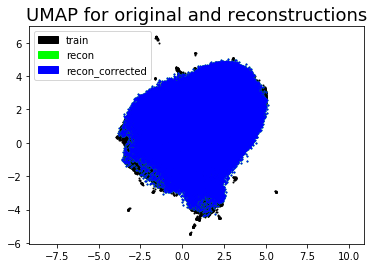

In [48]:
colors = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]
descriptions = ["train", "recon", "recon_corrected"]

plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=[[0, 0, 0]], s=1)
plt.scatter(embedding_recon_train[:, 0], embedding_recon_train[:, 1], c=[[0, 1, 0]], s=1)
plt.scatter(embedding_recon_train_corrected[:, 0], embedding_recon_train_corrected[:, 1], c=[[0, 0, 1]], s=1)
plt.gca().set_aspect('equal', 'datalim')

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, descriptions)] 
plt.legend(handles=handles)
plt.title('UMAP for original and reconstructions', fontsize=18)

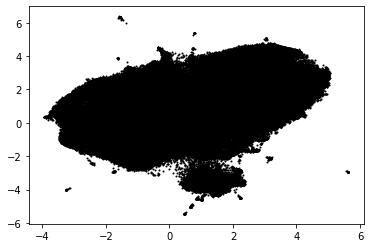

In [51]:
plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=[[0, 0, 0]], s=1)

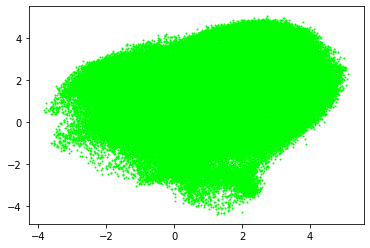

In [71]:
plt.scatter(embedding_recon_train[:, 0], embedding_recon_train[:, 1], c=[[0, 1, 0]], s=1)
# plt.scatter(train_z[:, 0], train_z[:, 1], c=[[1, 0, 0]], s=1)

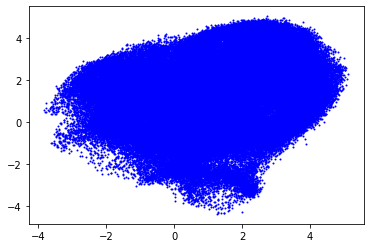

In [53]:
plt.scatter(embedding_recon_train_corrected[:, 0], embedding_recon_train_corrected[:, 1], c=[[0, 0, 1]], s=1)